number of simplices: 234760
number of unique simplices: 25027
Node index should begin with 0, reindexing the hypergraphs ...


INFO:root:Finish loading graphs.
INFO:root:Nodes train: 998
INFO:root:Simplicies train: 25027


number of nodes in construct graph 998


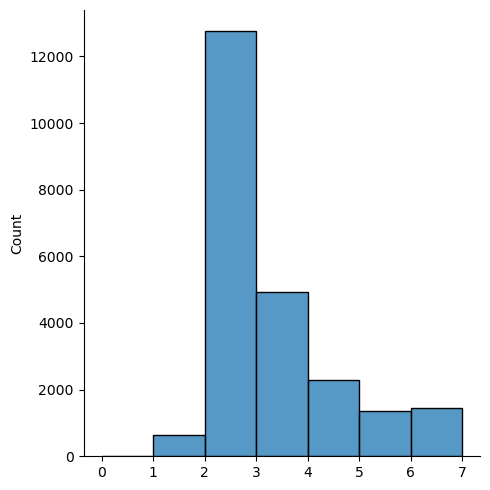

In [36]:
# load the hypergraph
import yaml
import logging
import os
import sys
import random

import numpy as np
import seaborn as sns
import networkx as nx

from utils import load_graphs
from cliques import compute_cliques


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

config  = yaml.safe_load(open('./config.yml'))
config['dataset'] = 'email-Eu'
config['beta'] = 150000
graphs = load_graphs(config, logger)


data = np.array([len(s) for s in graphs['simplicies_train']])
hist, bins = np.histogram(data, bins=np.linspace(1, 8, 8))
sns.displot(data, bins=range(8))

INFO:root:Start computing cliques
INFO:root:Found cache for max cliques train
INFO:root:Number of maximum cliques:237231
INFO:root:Optimizing clique sampler .. 
INFO:root:Found cache for rho.
INFO:root:[(2, 2), (1, 1), (3, 2), (2, 1), (4, 2), (3, 1), (5, 2), (3, 3), (6, 2), (4, 1), (4, 4), (4, 3), (7, 2), (5, 3)]
INFO:root:Optimize Clique Sampler: #hyperedges collected:10263, recall: 0.4100771167139489, efficiency:0.06842
INFO:root:Clique analysis done.


(0, 0), (116, 116), (135, 135), (951, 631), (1183, 742), (4957, 2127), (5773, 2356), (18853, 4925), (19125, 4966), (54525, 7685), (57041, 7840), (57670, 7875), (60186, 7956), (137088, 10009), 
len of origin: 149998, len of deduplicates: 31406


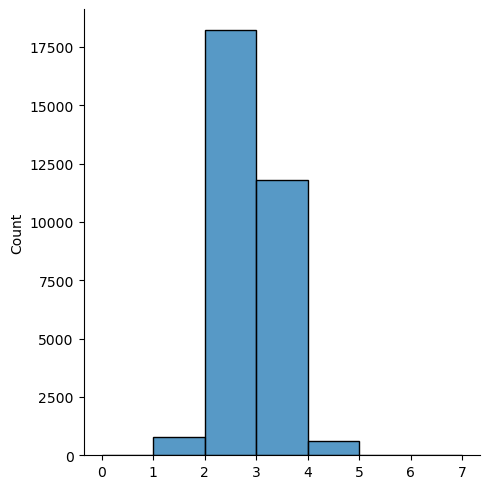

In [37]:
# # sampling cliques
# os.remove(f'{config['data_dir']}/{config['dataset']}/cliques_train.pkl')
# os.remove(f'{config['data_dir']}/{config['dataset']}/rho.pkl')

cliques = compute_cliques(graphs, config, logger)
sample_cliques_table = cliques['children_cliques_train']
# print(sample_cliques_table)

sample_cliques = []

for v in sample_cliques_table.values():
    sample_cliques = sample_cliques + v

sample_cliques = [list(c) for c in sample_cliques]
set_sample_cliques = list(set([tuple(sorted(e)) for e in sample_cliques]))
print(f'len of origin: {len(sample_cliques)}, len of deduplicates: {len(set_sample_cliques)}')

# random.shuffle(set_sample_hyperedges)
sample_clique_sizes = [len(c) for c in set_sample_cliques]
data = np.array(sample_clique_sizes)
hist, bins = np.histogram(data, bins=np.linspace(0, 5, 6))
sns.displot(data, bins=range(8))

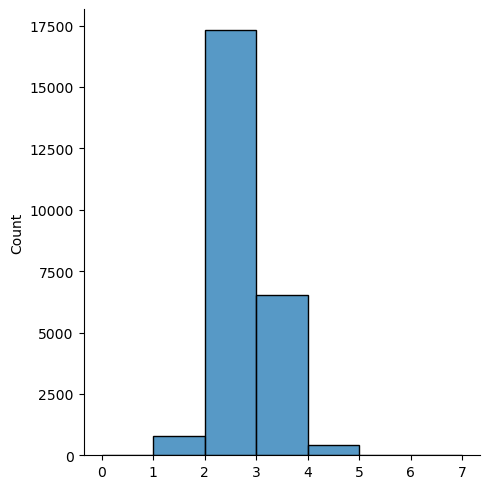

In [38]:
import utils
# from utils import lazy_clique_edge_cover
from importlib import reload
reload(utils)

# reconstruct the hypergraph by clique cover
G = graphs['G_weighted']

# YOU GUY!!!!!!!!!!!!!!!!!!!!!!
# BAD API!!!!!!!!!!!!!!!!!!!!!!
weighted_adjacency_matrix = nx.to_numpy_array(G, nodelist=sorted(G.nodes()))
reconstruct_hyperedges = utils.lazy_clique_edge_cover(weighted_adjacency_matrix, set_sample_cliques, len(graphs['simplicies_train']))
reconstruct_hyperedges_sizes = [len(e) for e in reconstruct_hyperedges]

data = np.array(reconstruct_hyperedges_sizes)
hist, bins = np.histogram(data, bins=np.linspace(0, 5, 6))
sns.displot(data, bins=range(8))

In [39]:
# print(reconstruct_hyperedges)
set_reconstruct_hyperedges = set([tuple(sorted(e)) for e in reconstruct_hyperedges])
print(f'len: {len(graphs['simplicies_train'])}, {graphs['simplicies_train']}')
print(f'len: {len(set_reconstruct_hyperedges)}, {set_reconstruct_hyperedges}')

precision, recall, f1, jaccard = utils.get_performance_wrt_ground_truth(set_reconstruct_hyperedges, graphs['simplicies_train'])
print(f'precision: {precision}, recall: {recall}, f1: {f1}, jaccard: {jaccard}')


len: 25027, {(249, 853), (16, 93), (191, 848), (591, 967), (19, 44, 106, 324, 365), (83, 283, 296), (26, 29, 38, 40, 446), (160, 222), (69, 212, 260, 506), (86, 508, 523), (172, 432, 471), (48, 166), (107, 746), (83, 160), (52, 146, 232, 396), (329, 566), (20, 21, 160), (18, 115), (116, 458), (156, 182, 350, 377, 390, 570, 591, 773, 848, 869, 904, 914), (179,), (308, 388, 389), (58, 59, 252, 402), (1, 106, 189, 377), (113, 160), (119, 151, 261, 367, 425, 468, 653), (40, 813), (339, 880), (529,), (160, 356), (62, 106, 183), (11, 233), (145, 233), (139, 418), (410, 881), (64, 244), (564, 567), (44, 531), (2, 305), (107, 158, 956), (24, 64), (84, 115), (6, 424), (47, 415, 441), (105, 403), (86, 508, 523, 762), (106, 145, 160, 188), (62, 706), (42, 44, 106, 114, 129, 280, 365, 471, 605), (340, 529, 808), (128, 129, 172), (81, 142, 416), (106, 254), (85, 226, 314), (211, 271, 696, 736), (87, 105, 432), (663,), (71, 121, 160, 217, 282, 366, 430, 544, 610), (58, 183), (108, 300), (52, 368), (